<h1>Company: Reliance Industries Limited</h1>
<h3>Data set used: 12/31/1995 - 11/3/2018</h3>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
from scipy.stats import zscore
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import numpy as np


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [x for x in window]
        x.append(window)
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [3]:
path = "./data/"
    
filename = os.path.join(path,"RELIANCE.NS.csv")
df = pd.read_csv(filename, na_values=['NA','?','null'])

df_work=df.drop(columns=['Date','Adj Close'], axis=1)

<h3>Drop the null values</h3>

In [4]:
print(df_work.shape)

modified_df = df_work.dropna()
print(modified_df.shape)


(5772, 5)
(5652, 5)


<h3>Feature Normalization</h3>

In [5]:
modified_df['Open']=zscore(modified_df['Open'])
modified_df['High'] = zscore(modified_df['High'])
modified_df['Low'] = zscore(modified_df['Low'])
modified_df['Volume'] = zscore(modified_df['Volume'])

x1 = modified_df['Open'].values.reshape( len(modified_df['Open']),1)
x2 = modified_df['High'].values.reshape( len(modified_df['High']),1)
x3 = modified_df['Low'].values.reshape( len(modified_df['Low']),1)
x4 = modified_df['Volume'].values.reshape( len(modified_df['Volume']),1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

<h3>Fully-Connected Neural Network</h3>

In [6]:
import math as Math
x = np.concatenate([x1,x2,x3,x4],axis=1)
y = modified_df['Close']
# Split into train/test
train_set_size = x.shape[0] * 0.70
train_set_size = Math.ceil(train_set_size)

x_train = x[0:train_set_size]
x_test = x[train_set_size+1 : x.shape[0]]
y_train = y[0:train_set_size]
y_test = y[train_set_size+1 : x.shape[0]]

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt


model = Sequential()
model.add(Dense(250, input_dim=x.shape[1], activation='relu'))
model.add(Dense(67, activation='relu'))
model.add(Dense(430, activation='relu'))
model.add(Dense(86,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)  
model.load_weights('best_weights.hdf5')

Train on 3957 samples, validate on 1694 samples
Epoch 1/1000
3957/3957 [==============================] - 0s 96us/step - loss: 15444.8049 - val_loss: 2084.6285
Epoch 2/1000
3957/3957 [==============================] - 0s 39us/step - loss: 390.6875 - val_loss: 1848.5323
Epoch 3/1000
3957/3957 [==============================] - 0s 38us/step - loss: 198.2615 - val_loss: 650.6246
Epoch 4/1000
3957/3957 [==============================] - 0s 39us/step - loss: 161.2289 - val_loss: 67.7985
Epoch 5/1000
3957/3957 [==============================] - 0s 39us/step - loss: 167.3559 - val_loss: 103.4914
Epoch 6/1000
3957/3957 [==============================] - 0s 38us/step - loss: 145.5078 - val_loss: 1103.6282
Epoch 7/1000
3957/3957 [==============================] - 0s 39us/step - loss: 153.9577 - val_loss: 183.9790
Epoch 8/1000
3957/3957 [==============================] - 0s 37us/step - loss: 137.9942 - val_loss: 494.2702
Epoch 9/1000
3957/3957 [==============================] - 0s 37us/step - los

In [11]:
pred = model.predict(x_test)
from sklearn import metrics
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
from sklearn.metrics import r2_score
score = r2_score(y_test, pred)  
print(score)

Final score (RMSE): 4.6146394028420685
0.9995422683998931


<h3>Regression Lift Chart : Fully-Connected Neural Network</h3>

In [12]:
print(y_test[0:5])
y_test_array = y_test.values.reshape( len(y_test),1)
print(y_test.shape)
print(y_test_array.shape)
print(pred[0:5])

4072    356.725006
4073    374.000000
4074    377.274994
4075    373.200012
4076    380.500000
Name: Close, dtype: float64
(1694,)
(1694, 1)
[[360.0853 ]
 [367.5671 ]
 [371.5705 ]
 [375.92435]
 [375.93216]]


(1694, 1)
(1694, 1)


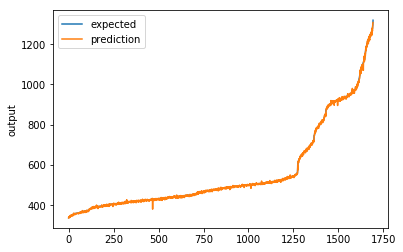

In [13]:
print(pred.shape)
print(y_test_array.shape)

pred_list=pred.flatten()

y_test_list = y_test_array.flatten()
chart_regression(pred_list,y_test_list)

<h3>RNN</h3>

In [14]:
df=df.drop(columns=['Date','Adj Close'], axis=1)
df = df_work.dropna()

In [15]:
modified_df['Close'] = zscore(modified_df['Close'])
x5 = modified_df['Close'].values.reshape( len(modified_df['Close']),1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
train_set_size = modified_df.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = modified_df[0:train_set]
df_test = modified_df[train_set+1 : modified_df.shape[0]]

close_train = df_train.values
close_test = df_test.values
train_unnormalise_close = df[0:train_set]
test_unnormalise_close = df[train_set+1 : modified_df.shape[0]]
train_unnormalise_close = train_unnormalise_close['Close'].tolist()
test_unnormalise_close =test_unnormalise_close['Close'].tolist()

print("Training set has {} records.".format(len(close_train)))
print("Test set has {} records.".format(len(close_test)))


Training set has 3957 records.
Test set has 1694 records.


In [17]:
SEQUENCE_SIZE = 7

x_train,y_train = to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3949, 7, 5)
Shape of x_test: (1686, 7, 5)
Shape of y_train: (3949,)
Shape of y_test: (1686,)


In [18]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()

model.add(LSTM(125, dropout=0.1, recurrent_dropout=0.1,input_shape=(SEQUENCE_SIZE, 5),activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(43, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2, epochs=500)

Build model...
Train...
Train on 3949 samples, validate on 1686 samples
Epoch 1/500
 - 2s - loss: 23367.8300 - val_loss: 9594.7660
Epoch 2/500
 - 1s - loss: 3540.7507 - val_loss: 13205.8605
Epoch 3/500
 - 1s - loss: 2513.4282 - val_loss: 2076.8250
Epoch 4/500
 - 1s - loss: 1982.6606 - val_loss: 29546.5001
Epoch 5/500
 - 1s - loss: 1682.6170 - val_loss: 2926.2268
Epoch 6/500
 - 1s - loss: 1396.2201 - val_loss: 1795.7526
Epoch 7/500
 - 1s - loss: 1269.1804 - val_loss: 19498.2838
Epoch 8/500
 - 1s - loss: 1181.3200 - val_loss: 3205.4593
Epoch 9/500
 - 1s - loss: 1091.1740 - val_loss: 26032.2867
Epoch 10/500
 - 1s - loss: 929.8163 - val_loss: 654.8870
Epoch 11/500
 - 1s - loss: 901.1995 - val_loss: 870.1664
Epoch 12/500
 - 1s - loss: 774.4248 - val_loss: 862.8407
Epoch 13/500
 - 1s - loss: 743.0771 - val_loss: 17955.9703
Epoch 14/500
 - 1s - loss: 730.1618 - val_loss: 15670.1424
Epoch 15/500
 - 1s - loss: 722.1252 - val_loss: 873.9696
Epoch 16/500
 - 1s - loss: 680.4277 - val_loss: 679.802

In [19]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
score = r2_score(y_test, pred)  
print("Score (R2): {}".format(score))

Score (RMSE): 61.23800845482878
Score (R2): 0.9192431025780018


<h3>Regression Lift Chart: RNN</h3>

(1686, 1)
(1686,)


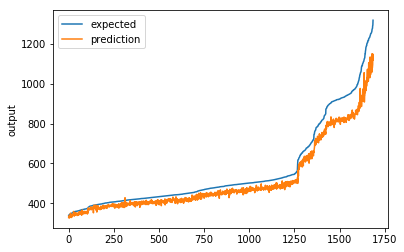

In [20]:
print(pred.shape)
print(y_test.shape)
pred_list=pred.flatten()
chart_regression(pred_list,y_test)

<h3> CNN </h3>

In [21]:
def cnn_to_sequences(seq_size, data, target):
    x = []
    y = []

    print(len(data)-SEQUENCE_SIZE-1)
    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [[x] for x in window]
        x.append(window)
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [22]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

SEQUENCE_SIZE = 7

x_train,y_train = cnn_to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = cnn_to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)
x_train = x_train.reshape(x_train.shape[0], 1, 7, 5)
x_test = x_test.reshape(x_test.shape[0], 1, 7, 5)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

3949
1686
Shape of x_train: (3949, 1, 7, 5)
Shape of x_test: (1686, 1, 7, 5)
Shape of y_train: (3949,)
Shape of y_test: (1686,)


In [23]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [24]:
input_shape = (1, 7, 5)
cnn2d = Sequential()
cnn2d.add(Conv2D(152, kernel_size=(1, 4), strides=(1, 2),
                 activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(52, (1,2), activation='relu'))
cnn2d.add(Flatten())
cnn2d.add(Dense(1, activation='relu'))

cnn2d.compile(optimizer='rmsprop',
              loss='mean_squared_error')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
cnn2d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 2, 152)         3192      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 52)          15860     
_________________________________________________________________
flatten_1 (Flatten)          (None, 52)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 53        
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
from sklearn import metrics

start_time = time.time()
for p in range(3):
    cnn2d.fit(x_train, y_train,     
              epochs=10000,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred = cnn2d.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    score = r2_score(y_test, pred)  
    print("Score (R2): {}".format(score))

Train on 3949 samples, validate on 1686 samples
Epoch 1/10000
 - 0s - loss: 78594.4719 - val_loss: 310203.1646
Epoch 2/10000
 - 0s - loss: 63067.6180 - val_loss: 201257.0622
Epoch 3/10000
 - 0s - loss: 40485.1237 - val_loss: 79423.0888
Epoch 4/10000
 - 0s - loss: 17733.0577 - val_loss: 18296.1416
Epoch 5/10000
 - 0s - loss: 6749.2740 - val_loss: 29848.9568
Epoch 6/10000
 - 0s - loss: 5177.0948 - val_loss: 22874.4391
Epoch 7/10000
 - 0s - loss: 4112.9478 - val_loss: 14166.6800
Epoch 8/10000
 - 0s - loss: 3237.8397 - val_loss: 6627.9834
Epoch 9/10000
 - 0s - loss: 2529.3439 - val_loss: 1578.5736
Epoch 10/10000
 - 0s - loss: 2022.8981 - val_loss: 1577.0833
Epoch 11/10000
 - 0s - loss: 1653.6123 - val_loss: 1786.6957
Epoch 12/10000
 - 0s - loss: 1371.6606 - val_loss: 1376.7640
Epoch 13/10000
 - 0s - loss: 1111.2135 - val_loss: 1100.0099
Epoch 14/10000
 - 0s - loss: 902.3884 - val_loss: 1451.9783
Epoch 15/10000
 - 0s - loss: 717.9211 - val_loss: 1036.2674
Epoch 16/10000
 - 0s - loss: 577.12

Epoch 138/10000
 - 0s - loss: 177.3759 - val_loss: 330.8556
Epoch 139/10000
 - 0s - loss: 186.2114 - val_loss: 428.4174
Epoch 140/10000
 - 0s - loss: 183.3441 - val_loss: 343.8044
Epoch 141/10000
 - 0s - loss: 179.8379 - val_loss: 468.9064
Epoch 142/10000
 - 0s - loss: 179.5615 - val_loss: 357.5304
Epoch 143/10000
 - 0s - loss: 184.6310 - val_loss: 282.8418
Epoch 144/10000
 - 0s - loss: 182.1225 - val_loss: 297.8041
Epoch 145/10000
 - 0s - loss: 182.9717 - val_loss: 305.5189
Epoch 146/10000
 - 0s - loss: 175.7131 - val_loss: 565.0815
Epoch 147/10000
 - 0s - loss: 183.0425 - val_loss: 339.8366
Epoch 148/10000
 - 0s - loss: 178.9249 - val_loss: 353.1501
Epoch 149/10000
 - 0s - loss: 180.7584 - val_loss: 525.3144
Epoch 150/10000
 - 0s - loss: 181.7361 - val_loss: 300.1313
Epoch 151/10000
 - 0s - loss: 169.4070 - val_loss: 585.1253
Epoch 152/10000
 - 0s - loss: 183.2347 - val_loss: 286.8419
Epoch 153/10000
 - 0s - loss: 177.4502 - val_loss: 350.5965
Epoch 154/10000
 - 0s - loss: 185.8995 -

<h3>Regression Lift Chart: CNN</h3>

(1686, 1)
(1686,)


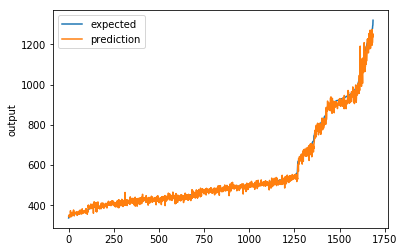

In [26]:
print(pred.shape)
print(y_test.shape)
pred_list=pred.flatten()
chart_regression(pred_list,y_test)